In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/jazzer/.pyenv/versions/3.6.10/bin/python (found version "3.6.10") 
-- Found PythonLibs: /home/jazzer/.pyenv/versions/3.6.10/lib/libpython3.6m.a
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/jazzer/Facultad/metodos_numericos_3/mt/tp3
-- Configuring done
-- Generating done
-- Build files have been written to: /home/jazzer/

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10


In [4]:
df = pd.read_csv('../data/train.csv')

In [5]:
df = df[df['ciudad']=='Mérida'].dropna()

In [30]:
x = df[['metroscubiertos']].values

In [31]:
y = df['precio'].values

In [32]:
x = x.reshape(len(x),1)
y = y.reshape(len(y),1)

In [33]:
x.shape

(518, 1)

In [34]:
from sklearn.linear_model import LinearRegression

"""
Reemplazar por nuestra implementación 
"""

#linear_regressor = LinearRegression()
linear_regressor = metnum.LinearRegression()

linear_regressor.fit(x,y)

In [35]:
df['prediction'] = linear_regressor.predict(x)

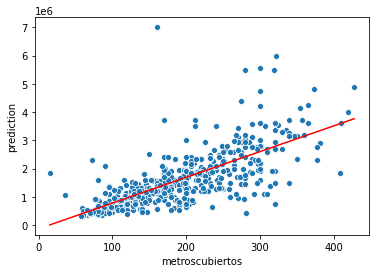

In [36]:
sns.scatterplot(data=df, x='metroscubiertos', y='precio')
sns.lineplot(data=df, x='metroscubiertos', y='prediction', color='red')


/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
0.6

--------------

0.65

--------------

0.7000000000000001

--------------

0.7500000000000001

--------------

0.8000000000000002

--------------

0.8500000000000002

--------------

0.9000000000000002

--------------

0.9500000000000003

--------------

{'rmse': [0.2875680988572798, 0.2871710572328904, 0.2870927295996959, 0.2874163216757408, 0.2870278414920376, 0.2848840771345667, 0.28668753201300146, 0.2868633234971915], 'rmsle': [0.1167789960846529, 0.116639718407611, 0.11661798652200035, 0.11674717560272091, 0.11660243323392647, 0.11579388670100822, 0.11646828499414043, 0.11653082198795602], 'percentage_of_train_cases': [0.6, 0.65, 0.7000000000000001, 0.7500000000000001, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.9500000000000003], 'time': [0.13350844383239746, 0.11733841896057129, 0.12227940559387207, 0.15734481811523438, 0.11006927490234375, 0.10660624504089355, 0.10946965217590332, 0.

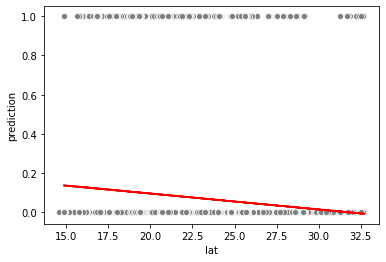

In [10]:

import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *

!pwd
!python --version
import metnum

def calculate_metrics(variable_to_predict, df):
    df = df[df['prediction'].notna()]
    return (math.sqrt(mean_squared_error(df[variable_to_predict], df['prediction'])),
            math.sqrt(mean_squared_log_error(df[variable_to_predict]+1, df['prediction']+1)))


def experiment(percentage_of_training_cases,
         variable_to_predict,
         variables_to_study,
         seed, 
         df,
         data):
    t0 = time.time()
    TOTAL_TRAIN_CASES = int(percentage_of_training_cases*len(df))

    df = df[0:].sample(frac=1, random_state=seed)
    
    #cleanup
    df = df[df[variable_to_predict].notna()]
    for var in variables_to_study:
        df = df[df[var].notna()]
    
    df_prediction = df[TOTAL_TRAIN_CASES:].copy()
    df_constant = df[TOTAL_TRAIN_CASES:].copy()
    df = df[:TOTAL_TRAIN_CASES]
    
#     print('length df: '+ str(len(df)))
#     print('length df_prediction: '+ str(len(df_prediction)))
#     print(df['lat'].sort_values().unique())
#     print(df['piscina'].unique()) 
#     print(df[df['lat'].isnull()])
#     print(df[df['piscina'].isnull()])

    x_train, y_train = df[variables_to_study].values, df[variable_to_predict].values
    x_predict, y_predict = df_prediction[variables_to_study].values, df_prediction[variable_to_predict].values
    
    x_train = x_train.reshape(len(x_train),len(variables_to_study))
    y_train = y_train.reshape(len(y_train),1)
    x_predict = x_predict.reshape(len(x_predict),len(variables_to_study))
    y_predict = y_predict.reshape(len(y_predict),1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x_train, y_train)
    df_prediction['prediction'] = linear_regressor.predict(x_predict)
    #df_constant['prediction'] = [0]*len(df_constant.index)
    t1 = time.time()
    total_time = (t1-t0)
    
    rmse, rmsle = calculate_metrics(variable_to_predict, df_prediction)
    data['rmse'].append(rmse)
    data['rmsle'].append(rmsle)
    data['percentage_of_train_cases'].append(percentage_of_training_cases)
    data['time'].append(total_time)
    
    if(len(variables_to_study)==1):
        sns.scatterplot(data=df, x=variables_to_study[0], y=variable_to_predict)
        sns.lineplot(data=df_prediction, x=variables_to_study[0], y='prediction', color='red')
    elif(len(variables_to_study)==2):
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('X', fontsize=15, rotation=150)
        ax.set_ylabel('Y')
        ax.set_zlabel(r'Z', fontsize=15)
        ax.scatter(df_prediction[variables_to_study[0]],
                   df_prediction[variables_to_study[1]],
                   df_prediction['prediction'], c='skyblue', s=60)
        ax.plot_trisurf(df_prediction[variables_to_study[0]], 
                        df_prediction[variables_to_study[1]], 
                        df_prediction['prediction'], cmap=plt.cm.viridis, linewidth=0.2)
        plt.show()
    return df_prediction
    
df = pd.read_csv('../data/train.csv')

# print(df.info()) 
df = df[df['lat'].notna()]
df = df[df['lat']<33]
df = df[df['lat']>14]

# df = df[df['ciudad']=='Mérida'].dropna()

d = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}

folder='./test_{}'.format(int(time.time()))

os.mkdir(folder)

# experiment(0.85, 'piscina', ['lat'], 666, df, d)

for i in np.arange(0.6, 1.0, 0.05):
    print(i)
    df_prediction = experiment(i, 'piscina', ['lat'], 666, df, d)
    df_prediction.to_csv(folder+'/prediction'+'_'+str(i)+'.csv', encoding='utf-8', index=False)
    print('\n--------------\n')
    
print(d)

(pd.DataFrame(data=d)
   .to_csv(folder+'/error.csv', encoding='utf-', index=False))


/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
0.9098496344323355


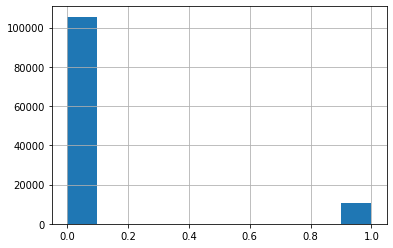

In [47]:
import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *

!pwd
!python --version
import metnum

df = pd.read_csv('../data/train.csv')

# print(df.info()) 
df = df[df['lat'].notna()]
df = df[df['lat']<33]
df = df[df['lat']>14]
df['piscina'].hist()

print(len(df[df['piscina']==0].index)/len(df.index))
# df['piscina'].hist(by='lat', label=i)
# for i in np.arange(15,30, 2.5):
#     df[(i<=df['lat']) & (df['lat'] <=(i+2.5))]['piscina'].hist(label=i)
# for i in np.arange(15,30, 2.5):
#     print(df[(i<=df['lat']) & (df['lat'] <=(i+2.5))].groupby('piscina'))

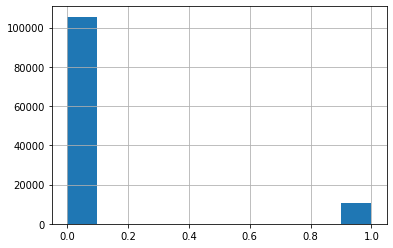

In [36]:
df['piscina'].hist()

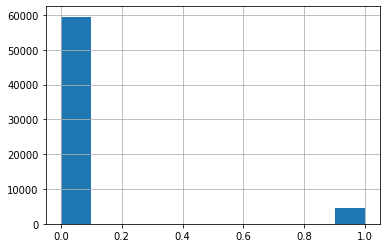

In [30]:
df[(17.5<=df['lat']) & (df['lat'] <=20)]['piscina'].hist()

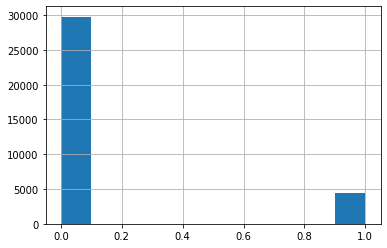

In [31]:
df[(20<=df['lat']) & (df['lat'] <=22.5)]['piscina'].hist()

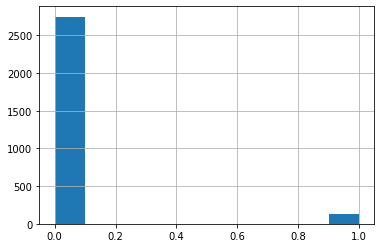

In [32]:
df[(22.5<=df['lat']) & (df['lat'] <=25)]['piscina'].hist()

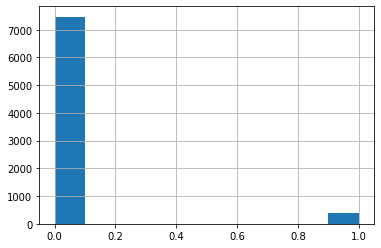

In [33]:
df[(25<=df['lat']) & (df['lat'] <=27.5)]['piscina'].hist()

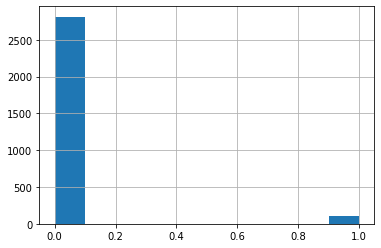

In [34]:
df[(27.5<=df['lat']) & (df['lat'] <=30)]['piscina'].hist()

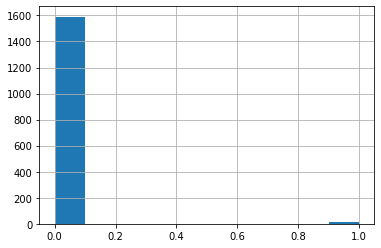

In [35]:
df[(30<=df['lat']) & (df['lat'] <=32.5)]['piscina'].hist()

/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipodepropiedad               239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
habitaciones                  217529 non-null float64
garages                       202235 non-null float64
banos                         213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
lat                           116512 non-null float64
lng           

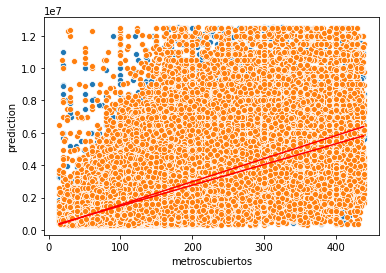

In [14]:

import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *

!pwd
!python --version
import metnum

def calculate_metrics(variable_to_predict, df):
    df = df[df['prediction'].notna()]
    return (math.sqrt(mean_squared_error(df[variable_to_predict], df['prediction'])),
            math.sqrt(mean_squared_log_error(df[variable_to_predict]+1, df['prediction']+1)))


def experiment(percentage_of_training_cases,
         variable_to_predict,
         variables_to_study,
         seed, 
         df,
         data):
    t0 = time.time()
    TOTAL_TRAIN_CASES = int(percentage_of_training_cases*len(df))

    df = df[0:].sample(frac=1, random_state=seed)
    
    #cleanup
    df = df[df[variable_to_predict].notna()]
    for var in variables_to_study:
        df = df[df[var].notna()]
    
    df_prediction = df[TOTAL_TRAIN_CASES:].copy()
    df_constant = df[TOTAL_TRAIN_CASES:].copy()
    df = df[:TOTAL_TRAIN_CASES]
    
#     print('length df: '+ str(len(df)))
#     print('length df_prediction: '+ str(len(df_prediction)))
#     print(df['lat'].sort_values().unique())
#     print(df['piscina'].unique()) 
#     print(df[df['lat'].isnull()])
#     print(df[df['piscina'].isnull()])

    x_train, y_train = df[variables_to_study].values, df[variable_to_predict].values
    x_predict, y_predict = df_prediction[variables_to_study].values, df_prediction[variable_to_predict].values
    
    x_train = x_train.reshape(len(x_train),len(variables_to_study))
    y_train = y_train.reshape(len(y_train),1)
    x_predict = x_predict.reshape(len(x_predict),len(variables_to_study))
    y_predict = y_predict.reshape(len(y_predict),1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x_train, y_train)
    df_prediction['prediction'] = linear_regressor.predict(x_predict)
    #df_constant['prediction'] = [0]*len(df_constant.index)
    t1 = time.time()
    total_time = (t1-t0)
    
    rmse, rmsle = calculate_metrics(variable_to_predict, df_prediction)
    data['rmse'].append(rmse)
    data['rmsle'].append(rmsle)
    data['percentage_of_train_cases'].append(percentage_of_training_cases)
    data['time'].append(total_time)
    
    if(len(variables_to_study)==1):
        sns.scatterplot(data=df, x=variables_to_study[0], y=variable_to_predict)
        sns.lineplot(data=df_prediction, x=variables_to_study[0], y='prediction', color='red')
    elif(len(variables_to_study)==2):
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('X', fontsize=15, rotation=150)
        ax.set_ylabel('Y')
        ax.set_zlabel(r'Z', fontsize=15)
        ax.scatter(df_prediction[variables_to_study[0]],
                   df_prediction[variables_to_study[1]],
                   df_prediction['prediction'], c='skyblue', s=60)
        ax.plot_trisurf(df_prediction[variables_to_study[0]], 
                        df_prediction[variables_to_study[1]], 
                        df_prediction['prediction'], cmap=plt.cm.viridis, linewidth=0.2)
        plt.show()
    return df_prediction
    
df = pd.read_csv('../data/train.csv')

print(df.info()) 

# df['centroscomercialescercanos'].hist()

df_comodo = df.copy()

df_comodo = df_comodo[df_comodo['centroscomercialescercanos'] == 1 ]
df_comodo = df_comodo[df_comodo['escuelascercanas']==1]

# print(df_comodo.info())
# df_comodo['escuelascercanas'].hist()
# df_comodo['centroscomercialescercanos'].hist()

df_no_comodo = df.copy()

df_no_comodo = df_no_comodo[df_no_comodo['centroscomercialescercanos'] == 0 ]
df_no_comodo = df_no_comodo[df_no_comodo['escuelascercanas']==0]

# print(df_no_comodo.info())
# df_no_comodo['escuelascercanas'].hist()
# df_no_comodo['centroscomercialescercanos'].hist()

d = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}

folder='./test_{}'.format(int(time.time()))

os.mkdir(folder)

df_prediction_comodo = experiment(0.85, 'precio', ['metroscubiertos'], 666, df_comodo, d)
df_prediction_no_comodo = experiment(0.85, 'precio', ['metroscubiertos'], 666, df_no_comodo, d)

df_prediction_comodo.to_csv(folder+'/prediction_comodo.csv', encoding='utf-8', index=False)
df_prediction_no_comodo.to_csv(folder+'/prediction_no_comodo.csv', encoding='utf-8', index=False)

(pd.DataFrame(data=d)
   .to_csv(folder+'/error.csv', encoding='utf-', index=False))

# for i in np.arange(0.6, 1.0, 0.05):
#     print(i)
#     df_prediction = experiment(i, 'piscina', ['lat'], 666, df, d)
#     df_prediction.to_csv(folder+'/prediction'+'_'+str(i)+'.csv', encoding='utf-8', index=False)
#     print('\n--------------\n')
    
# print(d)

# (pd.DataFrame(data=d)
#    .to_csv(folder+'/error.csv', encoding='utf-', index=False))
